**ASSIGNMENT**

Set working directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/'Colab Notebooks'/DAMVAD

/content/drive/MyDrive/Colab Notebooks/DAMVAD


Import packages

In [ ]:
import pandas as pd 
import seaborn as sns
import networkx as nx
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
!pip install linearmodels
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

Load data and explore

In [ ]:
with open('full202052.dat', 'r') as csvfile:
  df = pd.read_csv(csvfile)

In [ ]:
print(df.dtypes)
df.nunique()

DECLARANT           int64
DECLARANT_ISO      object
PARTNER             int64
PARTNER_ISO        object
TRADE_TYPE         object
PRODUCT_NC         object
PRODUCT_SITC       object
PRODUCT_CPA2002    object
PRODUCT_CPA2008    object
PRODUCT_CPA2_1     object
PRODUCT_BEC        object
PRODUCT_BEC5       object
PRODUCT_SECTION    object
FLOW                int64
STAT_REGIME         int64
SUPP_UNIT          object
PERIOD              int64
VALUE_IN_EUROS      int64
QUANTITY_IN_KG      int64
SUP_QUANTITY        int64
dtype: object


DECLARANT               28
DECLARANT_ISO           28
PARTNER                246
PARTNER_ISO            245
TRADE_TYPE               3
PRODUCT_NC            9895
PRODUCT_SITC          3118
PRODUCT_CPA2002        302
PRODUCT_CPA2008        312
PRODUCT_CPA2_1         313
PRODUCT_BEC             21
PRODUCT_BEC5            69
PRODUCT_SECTION         22
FLOW                     2
STAT_REGIME              4
SUPP_UNIT               27
PERIOD                   1
VALUE_IN_EUROS     1463620
QUANTITY_IN_KG      789452
SUP_QUANTITY        228233
dtype: int64

Drop transactions not having monetary value

In [ ]:
df.drop(df[df.VALUE_IN_EUROS == 0].index, inplace=True)
df.shape

(9155383, 20)

Create adjacency matrix

In [ ]:
G = nx.DiGraph() 

for index, row in df.iterrows():
    G.add_edge(row[1],row[3],weight=row[17])

Calculate eigenvector centrality and colors for plotting

In [ ]:
ec = nx.eigenvector_centrality_numpy(G)
nx.set_node_attributes(G, ec, 'cent')
node_color = [float(G.nodes[v]['cent']) for v in G]

Aggregate exports per country and calculate node size for visualization

In [ ]:
total_exp = {}
avg_exp = {}

for exp in G.nodes(): 
     tx=sum([float(g) for exp,f,g in G.out_edges(exp, 'weight')])
     total_exp[exp] = tx
     avg_exp[exp] = np.mean([float(g) for exp,f,g in G.out_edges(exp, 'weight')])

nx.set_node_attributes(G, total_exp, 'total_exp')

node_size = [float(G.nodes[v]['total_exp']) / np.nanmean(list(avg_exp.values())) for v in G]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**Visualization of trade network**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  del sys.path[0]


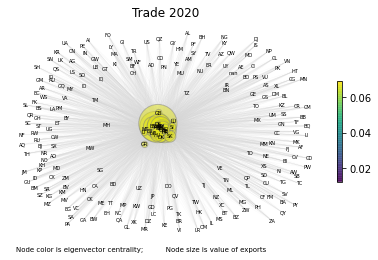

In [ ]:
pos = nx.spring_layout(G,k=30,iterations=8) 

nodes = nx.draw_networkx_nodes(G,pos, node_size=node_size, \
                               node_color=node_color, alpha=0.5) 
edges = nx.draw_networkx_edges(G, pos, edge_color='lightgray', \
                               arrows=False, width=0.05,)

nx.draw_networkx_labels(G,pos,font_size=5)
nodes.set_edgecolor('gray')

plt.text(-1,-1.2, \
         'Node color is eigenvector centrality; \
         Node size is value of exports', \
         fontsize=7)
plt.title('Trade 2020', fontsize=12)

cbar = plt.colorbar(mappable=nodes, cax=None, ax=None, fraction=0.015, pad=0.04)
cbar.set_clim(0, 1)

plt.margins(0,0)
plt.axis('off')

plt.savefig('network.png', dpi=1000)

The eigenvector centrality helps displaying which countries hold the most active trade relations (as in "most connected"), whereas the size of the node shows the value of the exports. Following intuition, more trade activity will allow for more value traded as shown in the graph.

**Relationship weight and value**


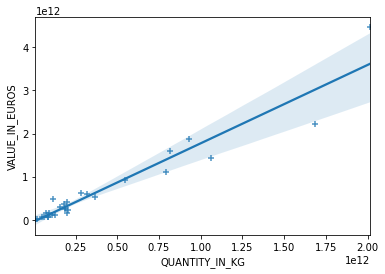

In [ ]:
sns.regplot(x='QUANTITY_IN_KG', y='VALUE_IN_EUROS', data=df_country, marker ='+', order=1)

A plot showing that more weight traded implies more value traded.

**Trade volume by country (descending order)**

In [ ]:
statistics = {'VALUE_IN_EUROS': "sum", 'QUANTITY_IN_KG': "sum"}
df_country = df.groupby('DECLARANT_ISO').agg(statistics).reset_index()
df_country['VALUE_EUROS_billions'] = df_country.apply(lambda row: row['VALUE_IN_EUROS'] / 1000000000, axis=1 )
df_country[['DECLARANT_ISO','VALUE_EUROS_billions']].sort_values("VALUE_EUROS_billions", ascending=False)[:10]

,DECLARANT_ISO,VALUE_EUROS_billions
5,DE,4463.759837
21,NL,2224.162643
10,FR,1873.247891
16,IT,1607.057430
1,BE,1428.791458
8,ES,1105.296556
22,PL,923.311055
4,CZ,633.840508
0,AT,598.445394
25,SE,534.545435


**Top 10 trade volume by country pairs**


In [ ]:
df_pairs = df.groupby(['DECLARANT_ISO','PARTNER_ISO']).agg(statistics).reset_index()
df_pairs['VALUE_EUROS_billions'] = df_pairs.apply(lambda row: row['VALUE_IN_EUROS'] / 1000000000, axis=1 )
df_pairs[['DECLARANT_ISO','PARTNER_ISO','VALUE_EUROS_billions']].sort_values("VALUE_EUROS_billions", ascending=False)[:10]

,DECLARANT_ISO,PARTNER_ISO,VALUE_EUROS_billions
1266,DE,NL,435.120364
4701,NL,DE,424.928714
1159,DE,CN,356.964482
1334,DE,US,309.465514
2315,FR,DE,300.594764
1185,DE,FR,300.328382
1278,DE,PL,261.287784
4945,PL,DE,260.341503
3660,IT,DE,232.002126
1215,DE,IT,230.869806


**Panel regression with exporter fixed effects**


In [ ]:
df['VALUE_EUROS_billions'] = df.apply(lambda row: row['VALUE_IN_EUROS'] / 1000000000, axis=1 )
panel_data = df[["DECLARANT", "PARTNER",'DECLARANT_ISO', 'PRODUCT_SECTION','PARTNER_ISO','VALUE_EUROS_billions']]
panel_data = panel_data.set_index(["DECLARANT", "PARTNER"])

In [ ]:
panel_data = sm.add_constant(panel_data)
dummies = pd.get_dummies(panel_data['PRODUCT_SECTION']).iloc[:, 1:]
panel_data = pd.concat([panel_data, dummies], axis=1)

In [ ]:
mod = PanelOLS(panel_data['VALUE_EUROS_billions'], panel_data[panel_data.columns.difference(['PRODUCT_SECTION','DECLARANT_ISO','PARTNER_ISO'])], entity_effects=True)
results = mod.fit()

A illustratory panel regression taking the production section dummies and exporter fixed effects to estimate which categories are the one that contributes the most. The analysis of the fixed effects values can be useful to identify the larger exporters in average. 